## <center><font color="purple">Single ML Regressors - Length of Stay Forecasting </font></center>
<center> Firuz Juraev (Sungkyunkwan University) </center>

#### <center><font color='green'> Keywords: LOS, Regression</font></center>

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.linear_model import Ridge 
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso 
from sklearn.ensemble import VotingRegressor

In [3]:
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error, 
                             r2_score, 
                             mean_squared_log_error)

In [4]:
# from yellowbrick.regressor import residuals_plot
# from yellowbrick.regressor import prediction_error

In [6]:
from sklearn.feature_selection import mutual_info_classif
# from featurewiz import featurewiz

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [10]:
# import dalex as dx

In [11]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Load Dataset 

In [12]:
dataset = pd.read_csv("Data/neonate_dataset.csv")

In [13]:
dataset.fillna(method="ffill", inplace=True)
y = dataset['LOS']
X = dataset.drop(['LOS'], axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

### Normalization

In [15]:
Min_max_scaler = MinMaxScaler().fit(X_train) 
### StandardScaler()

## Scaling 
X_train_mm_scaled = Min_max_scaler.transform(X_train)
X_test_mm_scaled = Min_max_scaler.transform(X_test)

## Numpy Array to DataFrame 
df_train_mm_scaled = pd.DataFrame(X_train_mm_scaled)
df_test_mm_scaled = pd.DataFrame(X_test_mm_scaled)

In [16]:
# feature selection
def select_features(X_train, y_train, X_test, k=70):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [17]:
X_train_fs, X_test_fs, fs = select_features(df_train_mm_scaled, y_train, df_test_mm_scaled)

### k-fold Cross Validation 

In [18]:
def cv_partitioning(df, k, fraction): 
    dataset_list = [] 
    
    for i in range(0, k): 
        dataset_list.append(df.sample(frac=fraction))
    
    return dataset_list

In [19]:
train_data = X_train[:]
train_data["LOS"] = y_train 

test_data = X_test[:]
test_data["LOS"] = y_test

In [20]:
train_data.shape

(1996, 91)

In [21]:
train_dfs = cv_partitioning(train_data, 10, 0.95)

### Defining Models 

In [22]:
def get_results(train, test, regressors): 
    
    train_x = train.drop(["LOS"], axis=1) 
    train_y = train["LOS"] 
    
    test_x = test.drop(["LOS"], axis=1) 
    test_y = test["LOS"]
    
    reg_names = [] 
    mse_scores = [] 
    mae_scores = [] 
    r2_scores = []    
    
    for reg in regressors:  
        reg.fit(train_x, train_y)
        y_preds = reg.predict(test_x)
        
        reg_names.append(reg.__class__.__name__)
        mse_scores.append(mean_squared_error(test_y, y_preds, squared=False))
        mae_scores.append(mean_absolute_error(test_y, y_preds))
        r2_scores.append(r2_score(test_y, y_preds))
        
    
    results = { 'name': reg_names, 
                'rmse': mse_scores, 
                'mae': mae_scores, 
                'r2': r2_scores, 
              }
       
    df = pd.DataFrame.from_dict(results)
    
    return df 

In [23]:
regressors = [KNeighborsRegressor(), LinearRegression(normalize=True), Ridge(), LinearSVR(C=0.02), DecisionTreeRegressor(), 
              Lasso()]

results_data = []
for i in range(0, 10): 
    results_data.append(get_results(train_dfs[i], test_data, regressors))

In [24]:
resultsDF = pd.concat(results_data)

In [25]:
names = ['KNeighborsRegressor', 'LinearRegression', 'LinearSVR', 'DecisionTreeRegressor', 'Ridge', 'Lasso']

rmse_list = [] 
rmse_std = [] 

mae_list = []
mae_std = [] 

r2_list = []
r2_std = [] 

for n in names: 
    rmse_list.append(resultsDF[resultsDF.name == n].rmse.mean())
    rmse_std.append(resultsDF[resultsDF.name == n].rmse.std()*10)
    mae_list.append(resultsDF[resultsDF.name == n].mae.mean())
    mae_std.append(resultsDF[resultsDF.name == n].mae.std()*10)
    r2_list.append(resultsDF[resultsDF.name == n].r2.mean()*100)   
    r2_std.append(resultsDF[resultsDF.name == n].r2.std()*100)

final_results = {"method": names, 
                "rmse": rmse_list, 
                "rmse_std": rmse_std, 
                "mae": mae_list, 
                "mae_std": mae_std, 
                "r2": r2_list, 
                "r2_std": r2_std}

final_resultsDF = pd.DataFrame.from_dict(final_results)

final_resultsDF

,method,rmse,rmse_std,mae,mae_std,r2,r2_std
0,KNeighborsRegressor,24.199852,1.517331,16.491426,1.198996,22.361321,0.971909
1,LinearRegression,16.165129,0.431497,11.672631,0.524501,65.358357,0.184877
2,LinearSVR,18.636141,19.120380,12.858917,13.294898,53.522328,9.781899
3,DecisionTreeRegressor,20.092007,3.905397,13.331261,2.977756,46.465763,2.075334
4,Ridge,16.160622,0.431599,11.666430,0.529675,65.377671,0.184876
5,Lasso,16.010026,0.343765,11.375444,0.391123,66.020015,0.145873


In [26]:
def change_format(x, name): 
    name_std = name + "_std"
    return str(round(x[name], 3)) + " ± " + str(round(x[name_std], 3)) 

In [27]:
final_resultsDF["rmse"] = final_resultsDF.apply(lambda x: change_format(x, 'rmse'), axis=1) 
final_resultsDF["mae"] = final_resultsDF.apply(lambda x: change_format(x, 'mae'), axis=1) 
final_resultsDF["r2"] = final_resultsDF.apply(lambda x: change_format(x, 'r2'), axis=1) 

final_resultsDF.drop(["rmse_std", "mae_std", "r2_std"], axis=1, inplace=True)

In [28]:
final_resultsDF

,method,rmse,mae,r2
0,KNeighborsRegressor,24.2 ± 1.517,16.491 ± 1.199,22.361 ± 0.972
1,LinearRegression,16.165 ± 0.431,11.673 ± 0.525,65.358 ± 0.185
2,LinearSVR,18.636 ± 19.12,12.859 ± 13.295,53.522 ± 9.782
3,DecisionTreeRegressor,20.092 ± 3.905,13.331 ± 2.978,46.466 ± 2.075
4,Ridge,16.161 ± 0.432,11.666 ± 0.53,65.378 ± 0.185
5,Lasso,16.01 ± 0.344,11.375 ± 0.391,66.02 ± 0.146


In [26]:
# final_resultsDF.to_csv("Results/single_regressor_result_raw-1.csv", index=False)

### Optimization 

In [52]:
selected_features_classification = [
     'temperature_mean',
     'respRate_std',
#      'respRate_var',
     'skinTemperature_std',
     'skinTemperature_var',
     'heartRate_std',
     'hrAlarmLow_max',
     'hrAlarmLow_std',
     'hrAlarmHigh_std', 
#      'heartRate_var',
#      'bpCuffMean_var',
     'sao2_std',
#      'bpCuffMean_std',
#      'sao2_var',
     'heartRate_mean',
#      'bpCuffSystolic_std',
     'respRate_mean',
#      'glucometer_var',
     'skinTemperature_mean',
#      'bpCuffSystolic_var',
#      'glucometer_std',
#      'bpCuffDiastolic_var',
     'bpCuffDiastolic_std',
     'BIRTH_WEIGHT',
     'bpCuffSystolic_mean',
     'bpCuffDiastolic_mean',
     'sao2_mean',
     'temperature_std',
#      'temperature_var',
#      'glucometer_mean',
     'bpCuffMean_mean',
     'PLATELET',
     'D10W_MEAN', 'ADMISSION_LOCATION', 'INSURANCE', 'GESTATION', 'WHITE_BLOOD', 
     'DATEEVENTS', 'DW10_COUNT', 'PRESCRIPTIONS', 'HEAD_CIRC'] 

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [77]:
train_data = X_train[selected_features_classification]
train_data["LOS"] = y_train 

test_data = X_test[selected_features_classification]
test_data["LOS"] = y_test

train_dfs = cv_partitioning(train_data, 10, 0.95)
test_dfs = cv_partitioning(test_data, 10, 0.95)

In [65]:
train_dfs[0].shape

(1896, 30)

In [89]:
regressors = [KNeighborsRegressor(n_neighbors=7, leaf_size=30, p=1, algorithm='auto'), 
              LinearRegression(), 
              Ridge(alpha=3), 
              Lasso(alpha=0.1, warm_start=True), 
              LinearSVR(C=0.009), 
              DecisionTreeRegressor(criterion='mse', max_depth=4)]

results_data = []
for i in range(0, 10): 
#     results_data.append(get_results(train_dfs[i], test_data, regressors))
    results_data.append(get_results(train_data, test_dfs[i], regressors))
    
resultsDF = pd.concat(results_data)

In [90]:
names = ['KNeighborsRegressor', 'LinearRegression', 'LinearSVR', 'DecisionTreeRegressor', 'Ridge', 'Lasso']

rmse_list = [] 
rmse_std = [] 

mae_list = []
mae_std = [] 

r2_list = []
r2_std = [] 

for n in names: 
    rmse_list.append(resultsDF[resultsDF.name == n].rmse.mean())
    rmse_std.append(resultsDF[resultsDF.name == n].rmse.std()*10)
    mae_list.append(resultsDF[resultsDF.name == n].mae.mean())
    mae_std.append(resultsDF[resultsDF.name == n].mae.std()*10)
    r2_list.append(resultsDF[resultsDF.name == n].r2.mean()*100)   
    r2_std.append(resultsDF[resultsDF.name == n].r2.std()*100)

final_results = {"method": names, 
                "rmse": rmse_list, 
                "rmse_std": rmse_std, 
                "mae": mae_list, 
                "mae_std": mae_std, 
                "r2": r2_list, 
                "r2_std": r2_std}

final_resultsDF = pd.DataFrame.from_dict(final_results)

final_resultsDF

,method,rmse,rmse_std,mae,mae_std,r2,r2_std
0,KNeighborsRegressor,18.119268,2.290549,11.760837,1.421647,53.891159,0.823647
1,LinearRegression,14.776441,1.917044,10.815325,1.056418,69.332773,0.689050
2,LinearSVR,16.015995,3.034710,10.760605,1.483260,63.978637,0.771926
3,DecisionTreeRegressor,15.026019,1.484889,10.324216,0.932655,68.287157,0.650493
4,Ridge,14.780444,1.921370,10.814248,1.056263,69.316169,0.689624
5,Lasso,14.820150,1.992752,10.799545,1.045764,69.151297,0.699554


In [91]:
resultsDF.to_csv("Results/single_regressors_full_results.csv" ,index=False)

In [92]:
final_resultsDF["rmse"] = final_resultsDF.apply(lambda x: change_format(x, 'rmse'), axis=1) 
final_resultsDF["mae"] = final_resultsDF.apply(lambda x: change_format(x, 'mae'), axis=1) 
final_resultsDF["r2"] = final_resultsDF.apply(lambda x: change_format(x, 'r2'), axis=1) 

final_resultsDF.drop(["rmse_std", "mae_std", "r2_std"], axis=1, inplace=True)

In [69]:
final_resultsDF

,method,rmse,mae,r2
0,KNeighborsRegressor,18.218 ± 1.077,11.805 ± 0.611,53.24 ± 0.553
1,LinearRegression,14.825 ± 0.196,10.842 ± 0.241,69.038 ± 0.082
2,LinearSVR,16.074 ± 1.18,10.785 ± 0.353,63.598 ± 0.536
3,DecisionTreeRegressor,15.815 ± 5.991,10.624 ± 2.206,64.716 ± 2.68
4,Ridge,14.828 ± 0.195,10.84 ± 0.238,69.024 ± 0.081
5,Lasso,14.867 ± 0.208,10.822 ± 0.246,68.861 ± 0.087


In [37]:
# final_resultsDF.to_csv("Results/single_regressor_result_optimized-1.csv", index=False)

### Voting 

In [93]:
voting = VotingRegressor([('lr', LinearRegression()), 
                        ('ridge', Ridge(alpha=2.5, max_iter=1500)),
                        ('dt', DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)), 
#                         ('las',  Lasso(alpha=0.1)), 
#                         ('knn', KNeighborsRegressor(n_neighbors=6, leaf_size=50, p=1))
                        ])

In [94]:
results_data = []
for i in range(0, 10): 
#     results_data.append(get_results(train_dfs[i], test_data, [voting]))
    results_data.append(get_results(train_data, test_dfs[i], [voting])) 

In [95]:
resultsDF = pd.concat(results_data)

names = ['VotingRegressor']


rmse_list = [] 
rmse_std = [] 

mae_list = []
mae_std = [] 

r2_list = []
r2_std = [] 

for n in names: 
    rmse_list.append(resultsDF[resultsDF.name == n].rmse.mean())
    rmse_std.append(resultsDF[resultsDF.name == n].rmse.std())
    mae_list.append(resultsDF[resultsDF.name == n].mae.mean())
    mae_std.append(resultsDF[resultsDF.name == n].mae.std())
    r2_list.append(resultsDF[resultsDF.name == n].r2.mean()*100)   
    r2_std.append(resultsDF[resultsDF.name == n].r2.std()*100)

final_results = {"method": names, 
                "rmse": rmse_list, 
                "rmse_std": rmse_std, 
                "mae": mae_list, 
                "mae_std": mae_std, 
                "r2": r2_list, 
                "r2_std": r2_std}

final_resultsDF = pd.DataFrame.from_dict(final_results)

final_resultsDF

,method,rmse,rmse_std,mae,mae_std,r2,r2_std
0,VotingRegressor,13.758227,0.170339,9.829068,0.104065,73.413735,0.569622


In [97]:
resultsDF.to_csv("Results/single_voting_full_results.csv" ,index=False)

### <font color='purple'> Critical Diagram 

In [41]:
def compare_results(results, lst_models):      
        fried_result = friedmanchisquare(*results)
        
        ranks = np.array([rankdata(-p) for p in results])
        
        # Calculating the average ranks.
        average_ranks = np.mean(ranks, axis=0)

        names = [lst_models[i] + ' - ' + str(round(average_ranks[i], 3)) for i in range(len(average_ranks))]
        
        # This method computes the critical difference for Nemenyi test with alpha=0.1.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd = compute_CD(average_ranks, n=len(results),alpha='0.05', test='nemenyi')
        
        # This method computes the critical difference for Bonferroni-Dunn test with alpha=0.05.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd1 = compute_CD(average_ranks, n=len(results), alpha='0.05', test='bonferroni-dunn')
        
        return fried_result, ranks, names, (cd, cd1), average_ranks

In [42]:
def plot_comparisons(fried_result, names, cd, cd1, average_ranks):    
    # This method generates the plot.
    graph_ranks(average_ranks, names=names,
                        cd=cd, width=10, textspace=1.5)
        
    plt.title(f'Friedman-Nemenyi={round(fried_result.pvalue, 4)}\nCD={round(cd, 3)}')
    plt.show()
    
    return

In [44]:
names = ['KNeighborsRegressor', 'LinearRegression', 'Ridge', 'LinearSVR', 
         'DecisionTreeRegressor', 'Lasso']

dct_results = {}

for n in names:
    res = resultsDF[resultsDF.name == n].r2.to_list()
    dct_results[n] = res

results = np.c_[dct_results['KNeighborsRegressor'], dct_results['LinearRegression'], dct_results['Ridge'], 
                dct_results['LinearSVR'], dct_results['DecisionTreeRegressor'], dct_results['Lasso']]

fried_result, ranks, names, (cd, cd1), average_ranks = compare_results(results, names)

ValueError: At least 3 sets of measurements must be given for Friedman test, got 0.

In [49]:
names

['KNeighborsRegressor - 6.0',
 'LinearRegression - 1.0',
 'Ridge - 2.0',
 'LinearSVR - 4.9',
 'DecisionTreeRegressor - 4.1',
 'Lasso - 3.0']

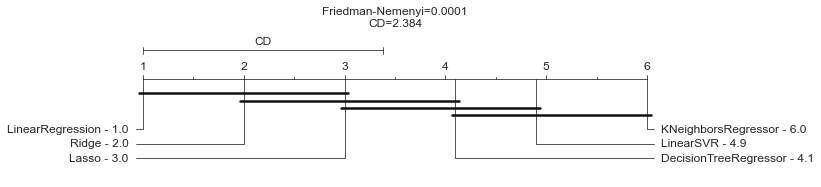

In [50]:
plot_comparisons(fried_result, names, cd, cd1, average_ranks)

In [53]:
# resultsDF.to_csv("Results/single_regressors_full_results.csv" ,index=False)

In [52]:
# resultsDF